# Fine-tuning a Model

The code in this notebook works through an example of fine-tuning a DistilBERT model using Hugging Face. The code accompanies my lessons as part of the Introduction to Hugging Face course available through 365DataScience.

## Choose model

In [16]:
model_name = 'distilbert-base-cased'

## Load dataset

In [17]:
from datasets import load_dataset

In [18]:
dataset = load_dataset("jonathanli/law-stack-exchange")

In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'LastActivityDate', 'AnswerCount', 'CommentCount', 'ContentLicense', 'body', 'text_label', 'title'],
        num_rows: 638
    })
    validation: Dataset({
        features: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'LastActivityDate', 'AnswerCount', 'CommentCount', 'ContentLicense', 'body', 'text_label', 'title'],
        num_rows: 319
    })
    test: Dataset({
        features: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'LastActivityDate', 'AnswerCount', 'CommentCount', 'ContentLicense', 'body', 'text_label', 'title'],
        num_rows: 1596
    })
})

In [20]:
dataset['train'][0]

{'Id': 71340,
 'PostTypeId': 1,
 'CreationDate': '2021-09-01T02:39:58.830',
 'Score': 0,
 'ViewCount': 128.0,
 'LastActivityDate': '2021-09-01T06:43:55.503',
 'AnswerCount': 1.0,
 'CommentCount': 9,
 'ContentLicense': 'CC BY-SA 4.0',
 'body': "I'm trying to comfortably use my laptop at night and now could not find an answer by web-search to the following: Why TVs / laptops etc. do not warn about too bright screen whereas many smartphones warn about too loud sound amplification? I'm asking on law site cause I suspect there were a number of successful lawsuits for impaired hearing from headphones but none for impaired vision from TVs. Am I right here? Digging down - has it happened because there are studies proving impairment for one and none for the other?\n\n\nAdded: I actually doubt my second guess cause there are a lot of enhancements in screen brightness - auto-brightness, night mode.\n\n\n",
 'text_label': 'civil-law',
 'title': 'Why TVs / laptops etc. do not warn about too brirght

## Prepare data

In [21]:
dataset = dataset.remove_columns(["Id", "PostTypeId", "CreationDate", 
                                  "Score", "ViewCount", "LastActivityDate",
                                  "AnswerCount", "CommentCount", "ContentLicense", 
                                  "title"])

In [22]:
dataset = dataset.rename_column("text_label", "label")
dataset = dataset.rename_column("body", "text")

In [23]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 638
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 319
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1596
    })
})

In [24]:
import pandas as pd

<Axes: >

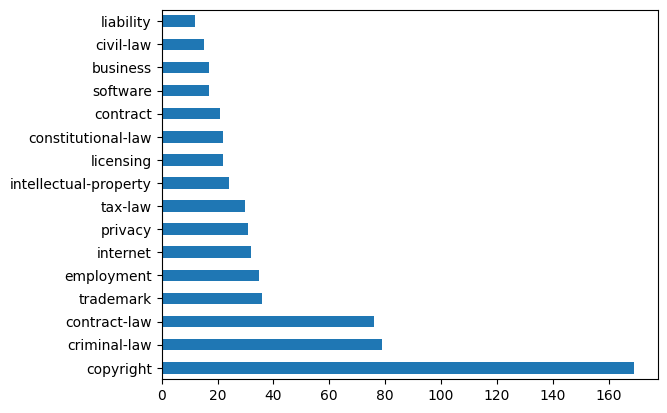

In [25]:
train_labels = pd.Series(dataset['train']['label']).value_counts()
train_labels.plot(kind='barh')

In [26]:
# balance the dataset and take just 4 classes
from datasets import concatenate_datasets

NUM_TRAINING_SAMPLES = 30
NUM_VAL_SAMPLES = 7
NUM_TESTING_SAMPLES = 5

# criminal-law 
label_6_train_data = dataset['train'].filter(lambda example: example["label"] == 'criminal-law').select(range(NUM_TRAINING_SAMPLES))
label_6_val_data = dataset['validation'].filter(lambda example: example["label"] == 'criminal-law').select(range(NUM_VAL_SAMPLES))
label_6_test_data = dataset['test'].filter(lambda example: example["label"] == 'criminal-law').select(range(NUM_TESTING_SAMPLES))
# employment
label_7_train_data = dataset['train'].filter(lambda example: example["label"] == 'employment').select(range(NUM_TRAINING_SAMPLES))
label_7_val_data = dataset['validation'].filter(lambda example: example["label"] == 'employment').select(range(NUM_VAL_SAMPLES))
label_7_test_data = dataset['test'].filter(lambda example: example["label"] == 'employment').select(range(NUM_TESTING_SAMPLES))
# tax-law 
label_14_train_data = dataset['train'].filter(lambda example: example["label"] == 'tax-law').select(range(NUM_TRAINING_SAMPLES))
label_14_val_data = dataset['validation'].filter(lambda example: example["label"] == 'tax-law').select(range(NUM_VAL_SAMPLES))
label_14_test_data = dataset['test'].filter(lambda example: example["label"] == 'tax-law').select(range(NUM_TESTING_SAMPLES))
# trademark
label_15_train_data = dataset['train'].filter(lambda example: example["label"] == 'trademark').select(range(NUM_TRAINING_SAMPLES))
label_15_val_data = dataset['validation'].filter(lambda example: example["label"] == 'trademark').select(range(NUM_VAL_SAMPLES))
label_15_test_data = dataset['test'].filter(lambda example: example["label"] == 'trademark').select(range(NUM_TESTING_SAMPLES))

In [27]:
train_data = concatenate_datasets([label_6_train_data, label_7_train_data, label_14_train_data, label_15_train_data])
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 120
})

In [28]:
val_data = concatenate_datasets([label_6_val_data, label_7_val_data, label_14_val_data, label_15_val_data])
val_data

Dataset({
    features: ['text', 'label'],
    num_rows: 28
})

In [29]:
test_data = concatenate_datasets([label_6_test_data, label_7_test_data, label_14_test_data, label_15_test_data])
test_data

Dataset({
    features: ['text', 'label'],
    num_rows: 20
})

In [30]:
NUM_LABELS = 4

In [31]:
# need to properly encode the labels 
from datasets import Dataset 

In [32]:
train_data.features

{'text': Value('string'), 'label': Value('string')}

In [33]:
def encode_labels(dataset):
    encoded_data = pd.DataFrame(dataset)
    encoded_data = Dataset.from_pandas(encoded_data)
    encoded_data = encoded_data.class_encode_column("label")
    return encoded_data

In [34]:
train_data = encode_labels(train_data)
val_data = encode_labels(val_data)
test_data = encode_labels(test_data)

Casting to class labels: 100%|██████████| 20/20 [00:00<00:00, 6492.73 examples/s]


In [35]:
train_data.features

{'text': Value('string'),
 'label': ClassLabel(names=['criminal-law', 'employment', 'tax-law', 'trademark'])}

In [36]:
# create id2label and label2id
labels = train_data.features['label'].names
ids = range(NUM_LABELS)
id2label = dict(zip(ids, labels))   
label2id = dict(zip(labels, ids)) 

In [37]:
# tokenize
from transformers import AutoTokenizer

In [38]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [39]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [40]:
tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_val = val_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)

Map: 100%|██████████| 20/20 [00:00<00:00, 3159.91 examples/s]


In [41]:
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_val = tokenized_val.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

In [42]:
tokenized_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 120
})

## Train model

In [43]:
from transformers import AutoModelForSequenceClassification

In [44]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, label2id=label2id, id2label=id2label)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
from transformers import TrainingArguments

In [47]:
training_args = TrainingArguments(output_dir="my_test_model", eval_strategy="epoch")

In [48]:
import numpy as np
import evaluate

In [49]:
metric = evaluate.load("accuracy")

In [50]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [51]:
from transformers import Trainer

In [52]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

In [53]:
trainer.train()

/Users/soubhik/Desktop/AI/full-stack-ai-with-python/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.255748,0.678571
2,No log,0.749143,0.821429
3,No log,0.573278,0.857143


/Users/soubhik/Desktop/AI/full-stack-ai-with-python/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/soubhik/Desktop/AI/full-stack-ai-with-python/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/soubhik/Desktop/AI/full-stack-ai-with-python/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=45, training_loss=0.9419576856825087, metrics={'train_runtime': 139.0776, 'train_samples_per_second': 2.588, 'train_steps_per_second': 0.324, 'total_flos': 47689964421120.0, 'train_loss': 0.9419576856825087, 'epoch': 3.0})

## Evaluate model

In [54]:
trainer.evaluate(tokenized_test)

/Users/soubhik/Desktop/AI/full-stack-ai-with-python/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.49166160821914673,
 'eval_accuracy': 0.95,
 'eval_runtime': 2.7452,
 'eval_samples_per_second': 7.286,
 'eval_steps_per_second': 1.093,
 'epoch': 3.0}

## Hyperparameter tuning

In [55]:
import optuna

In [56]:
# initialise a new model for each tuning run
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, label2id=label2id, id2label=id2label)

In [57]:
# function to control the search of hyperparams to tune
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_categorical("num_train_epochs", [2, 3, 5])
    }

In [58]:
# create the training args for each tuning run
tuning_training_args = TrainingArguments(
    output_dir="model_tuning_output",
    eval_strategy="epoch",
    learning_rate=0.1,  # Placeholder; will be overridden by the hyperparameter search
    per_device_train_batch_size=16,  # Placeholder; will be overridden by the hyperparameter search
    num_train_epochs=3,  # Placeholder; will be overridden by the hyperparameter search
    logging_dir="./logs",
    #push_to_hub=True
)

In [59]:
tuning_trainer = Trainer(
    model_init=model_init,
    args=tuning_training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
best_trial = tuning_trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=hp_space,
    n_trials=5
)

[I 2026-01-16 16:21:30,200] A new study created in memory with name: no-name-ad334aac-8e86-46ab-8499-8a418fa52109
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/soubhik/Desktop/AI/full-stack-ai-with-python/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


In [ ]:
print("Best Hyperparameters:", best_trial.hyperparameters)

In [ ]:
tuning_trainer.model.save_pretrained("my_tuned_model") # not used when pushing model to hub
#tuning_trainer.push_to_hub("my_tuned_model") # to be used when push_to_hub = True
tuning_trainer.processing_class.save_pretrained("tokenizer")

## Inference

In [ ]:
from transformers import pipeline
import random 

In [ ]:
my_model = AutoModelForSequenceClassification.from_pretrained("my_tuned_model")
#my_model = AutoModelForSequenceClassification.from_pretrained("lnewbould/my_tuned_model") # to be used when push_to_hub = True
my_tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:
my_text_classifier = pipeline("text-classification", model=my_model, tokenizer=my_tokenizer)

In [ ]:
random_sample = random.randint(0, len(test_data))
sample = test_data[random_sample]
sample_text = sample['text']
sample_label = sample['label']

In [ ]:
my_model_result = my_text_classifier(sample_text)

In [ ]:
print("Text to classify:\n", sample_text, 
      "\n\nThe correct label from the dataset:", sample_label, 
      "\nOur model classification:", my_model_result[0]['label'], "with a score of", my_model_result[0]['score'])

## Pushing model to hub

Will need to move this section up in finished file so hyperparam tuning can be uploaded to hub. 

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
my_model.push_to_hub("my_final_model")
my_tokenizer.push_to_hub("my_final_model")

## Gradio

In [ ]:
import gradio as gr

In [ ]:
demo = gr.Interface.from_pipeline(my_text_classifier)
demo.launch(share=True)